# Example 1: Umbrella Sampling in 1D

In this example, we will perform umbrella sampling along the **x-coordinate** for a particle on a 2-dimensional potential energy surface, and construct a free energy profile from the biased umbrella sampling data using WHAM.

We will use OpenMM to perform langevin dynamics simulations of a particle on a 2-dimensional potential energy surface. To learn more about OpenMM, visit https://openmm.org/

`single_particle_ld.py` contains the classes we will use to run these simulations.

In [1]:
# Imports
import os
import sys

import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import logsumexp

from WHAM import binless
from WHAM import binned
from WHAM.lib import potentials
from WHAM import statistics

sys.path.append('.')
import single_particle_ld

## Visualize potential

[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2


(<Figure size 900x600 with 2 Axes>, <AxesSubplot:xlabel='$x$', ylabel='$y$'>)

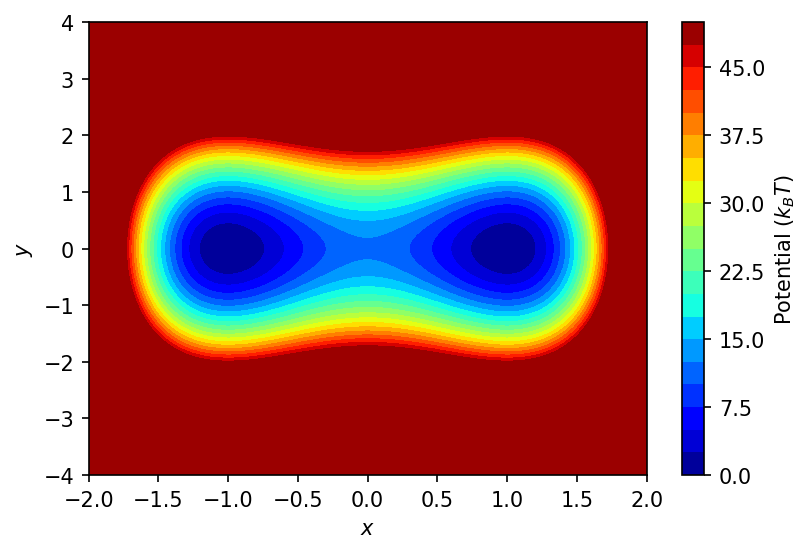

In [2]:
pot = single_particle_ld.TwoBasinPotential2D(magnitude=30)
vis = single_particle_ld.VisualizePotential2D(pot, temp=300,
                                              xrange=[-2, 2], yrange=[-4, 4],
                                              contourvals=20, clip=50)
vis.plot_potential()

## Unbiased simulation

Let's run a 500 ps unbiased simulation of a particle on this landscape:

In [3]:
if not os.path.exists("examples_out/1D_US/unbiased"):
    os.makedirs("examples_out/1D_US/unbiased")
    
pot = single_particle_ld.TwoBasinPotential2D(magnitude=30)

sim = single_particle_ld.SingleParticleSimulation(pot,
                                                  init_coord=np.array([[-1, -0, 0]]),
                                                  cpu_threads=1)
sim(nsteps=50000 + 1,
    chkevery=10000,
    trajevery=10,
    energyevery=10,
    chkfile="examples_out/1D_US/unbiased/chk_state.pkl",
    trajfile="examples_out/1D_US/unbiased/traj.dat",
    energyfile="examples_out/1D_US/unbiased/energies.dat")

t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/unbiased/traj.dat").read_traj()

[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
Running simulation on 1 CPU threads.


 29%|█████████▉                        | 14551/50001 [00:00<00:01, 29342.18it/s]

Checkpoint at 100.0000000 ps


 47%|███████████████▉                  | 23367/50001 [00:00<00:00, 29337.26it/s]

Checkpoint at 200.0000000 ps


 70%|███████████████████████▊          | 34962/50001 [00:01<00:00, 28642.75it/s]

Checkpoint at 300.0000000 ps


 87%|█████████████████████████████▋    | 43592/50001 [00:01<00:00, 28692.17it/s]

Checkpoint at 400.0000000 ps


100%|██████████████████████████████████| 50001/50001 [00:01<00:00, 28773.86it/s]

Checkpoint at 500.0000000 ps
Checkpoint at 500.0000000 ps


### Visualize time-series

Text(0, 0.5, 'y')

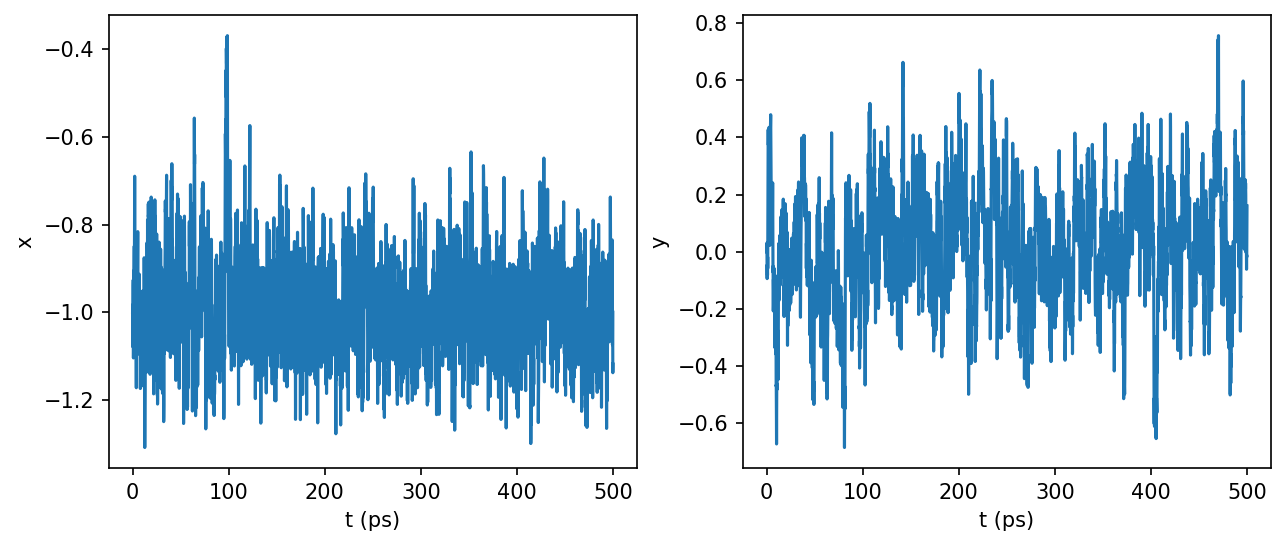

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
ax[0].plot(t, traj[:, 0])
ax[1].plot(t, traj[:, 1])
ax[0].set_xlabel("t (ps)")
ax[1].set_xlabel("t (ps)")
ax[0].set_ylabel("x")
ax[1].set_ylabel("y")

### Visualize trajectory in 2D

(<Figure size 900x600 with 2 Axes>, <AxesSubplot:xlabel='$x$', ylabel='$y$'>)

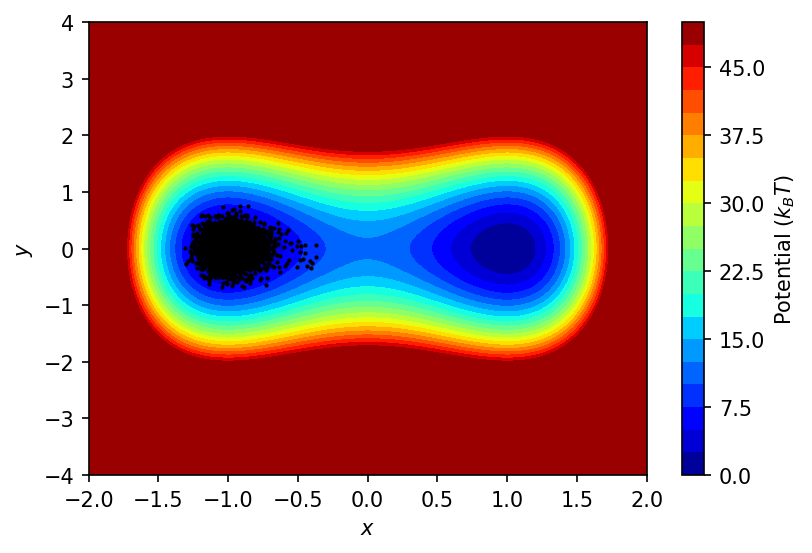

In [5]:
vis.scatter_traj(traj)

### Visualize trajectory in 1D

100%|██████████████████████████████████████| 5001/5001 [00:14<00:00, 344.44it/s]


(<Figure size 900x600 with 1 Axes>,
 <AxesSubplot:xlabel='$x$', ylabel='Potential ($k_B T$)'>)

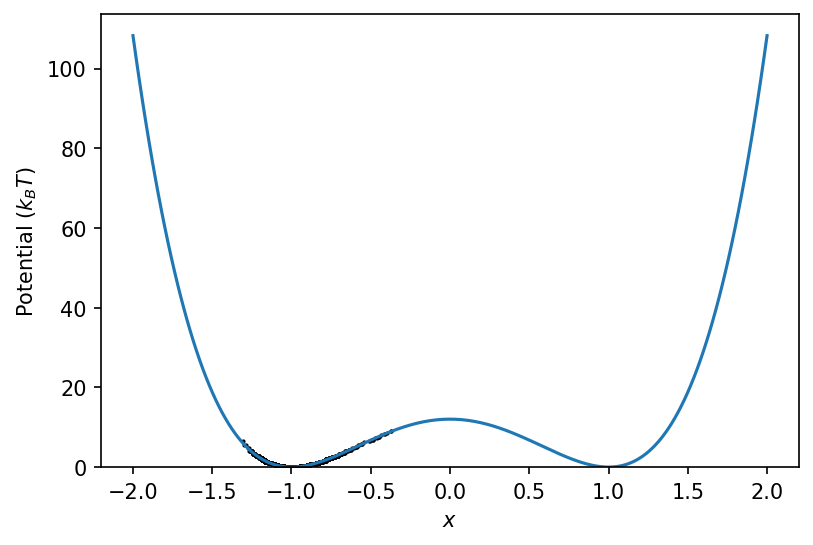

In [6]:
vis.scatter_traj_projection_x(traj)

## Biased simulation

We can localize the x-coordinate of the particle using a harmonic potential of the form $\frac{\kappa}{2} (x - x_0)^2$.

Here's an example, with $\kappa = 2$ and $x_0 = 0$.

In [7]:
if not os.path.exists("examples_out/1D_US/biased/test"):
    os.makedirs("examples_out/1D_US/biased/test")
    
pot = single_particle_ld.TwoBasinPotential2D(magnitude=30)

umbrella = single_particle_ld.HarmonicBias(kappa_x=200, x_0=0)

sim = single_particle_ld.SingleParticleSimulation(pot,
                                                  bias=umbrella,
                                                  init_coord=np.array([[-1, 0, 0]]),
                                                  cpu_threads=1)
sim(nsteps=50000 + 1,
    chkevery=10000,
    trajevery=10,
    energyevery=10,
    chkfile="examples_out/1D_US/biased/test/chk_state.pkl",
    trajfile="examples_out/1D_US/biased/test/traj.dat",
    energyfile="examples_out/1D_US/biased/test/energies.dat")

t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/test/traj.dat").read_traj()

[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 0)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 29%|█████████▋                        | 14283/50001 [00:00<00:01, 26895.01it/s]

Checkpoint at 100.0000000 ps


 51%|█████████████████▍                | 25691/50001 [00:00<00:00, 28206.71it/s]

Checkpoint at 200.0000000 ps


 69%|███████████████████████▍          | 34491/50001 [00:01<00:00, 28975.58it/s]

Checkpoint at 300.0000000 ps


 86%|█████████████████████████████▎    | 43144/50001 [00:01<00:00, 28683.62it/s]

Checkpoint at 400.0000000 ps


100%|██████████████████████████████████| 50001/50001 [00:01<00:00, 28224.97it/s]

Checkpoint at 500.0000000 ps
Checkpoint at 500.0000000 ps


Text(0, 0.5, 'y')

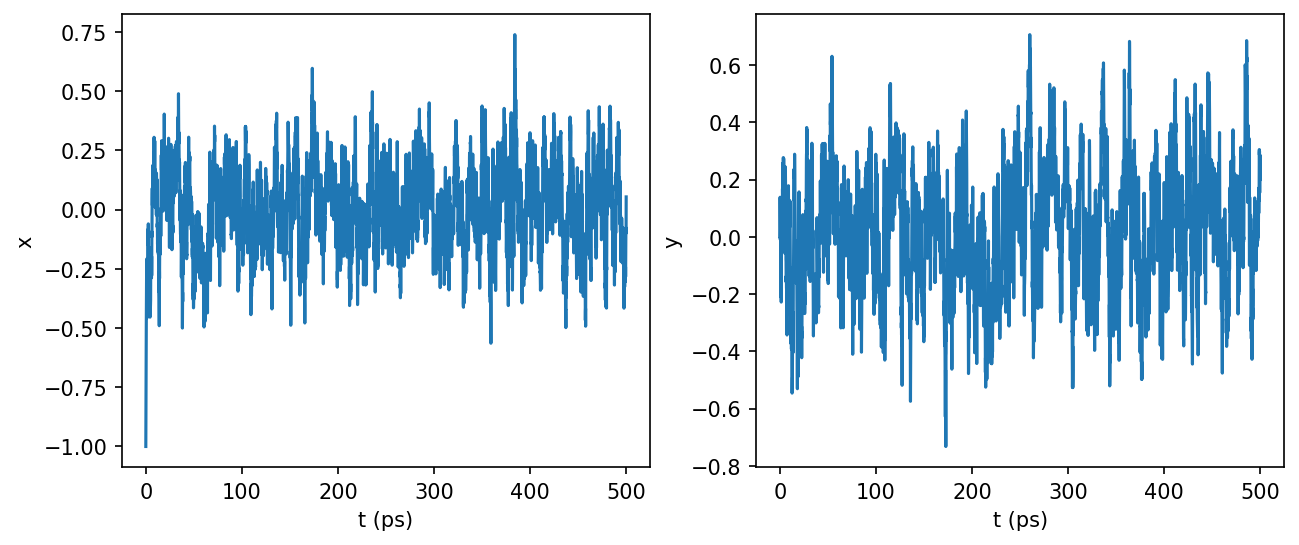

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
ax[0].plot(t, traj[:, 0])
ax[1].plot(t, traj[:, 1])
ax[0].set_xlabel("t (ps)")
ax[1].set_xlabel("t (ps)")
ax[0].set_ylabel("x")
ax[1].set_ylabel("y")

As we can see, it takes some time for the system to equilibrate. Let's discard the first 200 ps (i.e. 2000 data points) and plot the rest.

(<Figure size 900x600 with 2 Axes>, <AxesSubplot:xlabel='$x$', ylabel='$y$'>)

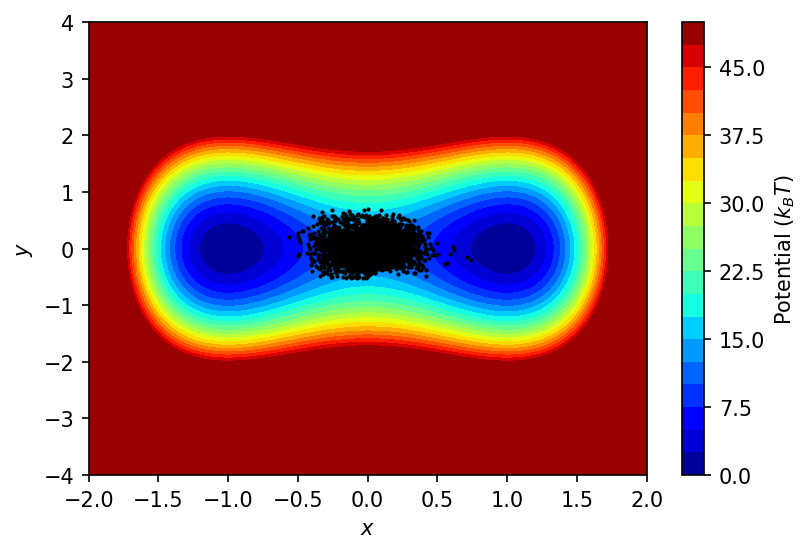

In [9]:
vis.scatter_traj(traj[2000:])

100%|██████████████████████████████████████| 3001/3001 [00:05<00:00, 523.92it/s]


(<Figure size 900x600 with 1 Axes>,
 <AxesSubplot:xlabel='$x$', ylabel='Potential ($k_B T$)'>)

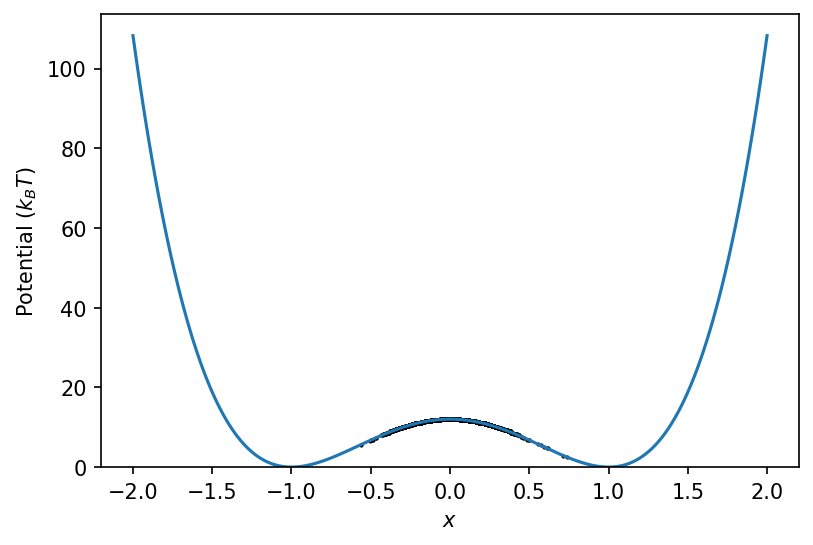

In [10]:
vis.scatter_traj_projection_x(traj[2000:])

## Umbrella sampling simulations

We can perform a series of such biased simulations with different values of $x_0$, and in the process, sample the entire landscape.

Let's set $\kappa = 200$ and $\Delta x_0 = 0.4$

In [11]:
kappa = 200
x_min = -2
x_max = 2
delta_x = 0.2
x_win = np.arange(x_min, x_max + delta_x, delta_x)

### 2 ns simulations

We'll perform these simulations for 2 ns each, so that we have enough data to construct free energy profiles.

In [12]:
for x_0 in x_win:
    if not os.path.exists("examples_out/1D_US/biased/k{}x{:.2f}".format(kappa, x_0)):
        os.makedirs("examples_out/1D_US/biased/k{}x{:.2f}".format(kappa, x_0))
    
    pot = single_particle_ld.TwoBasinPotential2D(magnitude=30)

    umbrella = single_particle_ld.HarmonicBias(kappa_x=kappa, x_0=x_0)

    sim = single_particle_ld.SingleParticleSimulation(pot,
                                                      bias=umbrella,
                                                      init_coord=np.array([[-1, 0, 0]]),
                                                      cpu_threads=1)
    sim(nsteps=200000 + 1,
        chkevery=100000,
        trajevery=10,
        energyevery=10,
        chkfile="examples_out/1D_US/biased/k{}x{:.2f}/chk_state.pkl".format(kappa, x_0),
        trajfile="examples_out/1D_US/biased/k{}x{:.2f}/traj.dat".format(kappa, x_0),
        energyfile="examples_out/1D_US/biased/k{}x{:.2f}/energies.dat".format(kappa, x_0))

[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -2.0)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▋               | 104117/200001 [00:03<00:03, 29414.92it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29386.90it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -1.8)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▋               | 104050/200001 [00:03<00:03, 29784.61it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29450.10it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -1.6)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▊               | 104851/200001 [00:03<00:03, 28279.14it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:07<00:00, 28532.63it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -1.4000000000000001)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 53%|████████████████▉               | 105691/200001 [00:03<00:03, 29618.64it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29313.26it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -1.2000000000000002)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 53%|████████████████▉               | 105544/200001 [00:03<00:03, 29047.68it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29293.93it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -1.0000000000000002)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▊               | 104941/200001 [00:03<00:03, 28858.06it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29118.99it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -0.8000000000000003)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103193/200001 [00:03<00:03, 29855.94it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29361.28it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -0.6000000000000003)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 53%|████████████████▉               | 105785/200001 [00:03<00:03, 29303.22it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29198.94it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -0.40000000000000036)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103451/200001 [00:03<00:03, 29322.37it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29252.01it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -0.2000000000000004)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▍               | 103079/200001 [00:03<00:03, 28882.90it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29111.34it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - -4.440892098500626e-16)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103857/200001 [00:03<00:03, 29842.06it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29348.89it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 0.1999999999999993)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103662/200001 [00:03<00:03, 28479.03it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 28939.21it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 0.39999999999999947)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 53%|████████████████▉               | 105668/200001 [00:03<00:03, 29683.84it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29465.72it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 0.5999999999999996)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 53%|████████████████▉               | 105585/200001 [00:03<00:03, 29138.29it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 28972.53it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 0.7999999999999994)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▍               | 103105/200001 [00:03<00:03, 29285.09it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29457.59it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 0.9999999999999991)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103341/200001 [00:03<00:03, 29469.41it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29506.23it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 1.1999999999999993)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103151/200001 [00:03<00:03, 29711.05it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29484.55it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 1.3999999999999995)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103173/200001 [00:03<00:03, 29703.30it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29359.87it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 1.5999999999999992)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103777/200001 [00:03<00:03, 29540.40it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29176.34it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 1.799999999999999)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103663/200001 [00:03<00:03, 28436.51it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29406.69it/s]


Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps
[Potential] Initializing potential with expression:
30 * ((x^2 - 1)^2 + y^2) + 1000 * z^2
[Bias] Initializing bias with expression:
200 / 2 * (x - 1.9999999999999991)^2 + 0 / 2 * (y - 0)^2 + 1000 * z^2
Running simulation on 1 CPU threads.


 52%|████████████████▌               | 103321/200001 [00:03<00:03, 29482.31it/s]

Checkpoint at 1000.0000000 ps


100%|████████████████████████████████| 200001/200001 [00:06<00:00, 29301.16it/s]

Checkpoint at 2000.0000000 ps
Checkpoint at 2000.0000000 ps


### Equilibration cutoff

Let's look at timeseries data from the window furthest away from the starting configuration. We can use this to set an equilibration threshold time.

In [13]:
t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k200x1.20/traj.dat").read_traj()

Text(0, 0.5, 'y')

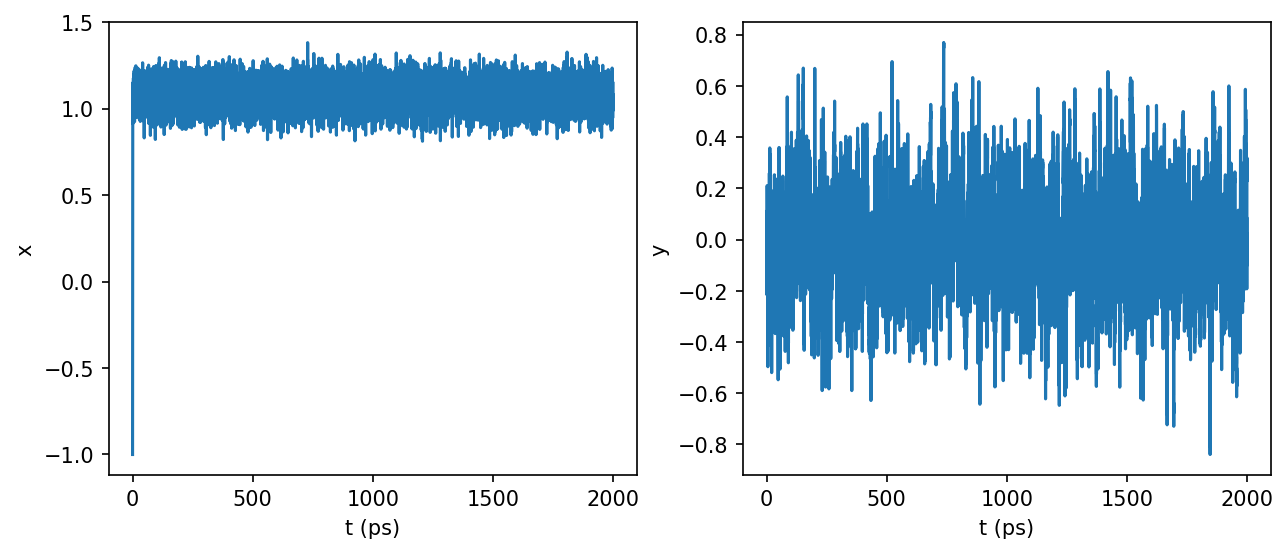

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=150)
ax[0].plot(t, traj[:, 0])
ax[1].plot(t, traj[:, 1])
ax[0].set_xlabel("t (ps)")
ax[1].set_xlabel("t (ps)")
ax[0].set_ylabel("x")
ax[1].set_ylabel("y")

Let's choose 200 ps (2000 steps) as our equilibration time

(<Figure size 900x600 with 2 Axes>, <AxesSubplot:xlabel='$x$', ylabel='$y$'>)

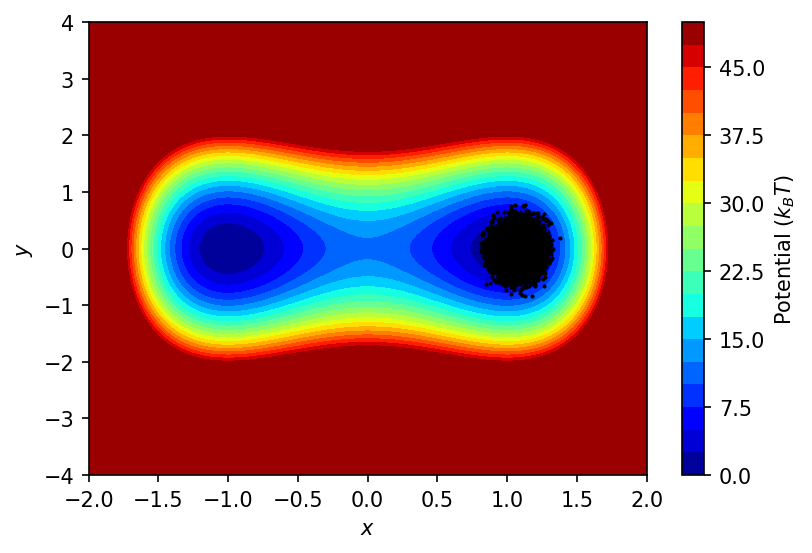

In [15]:
vis.scatter_traj(traj[2000:])

100%|██████████████████████████████████████| 1801/1801 [00:02<00:00, 663.59it/s]


(<Figure size 900x600 with 1 Axes>,
 <AxesSubplot:xlabel='$x$', ylabel='Potential ($k_B T$)'>)

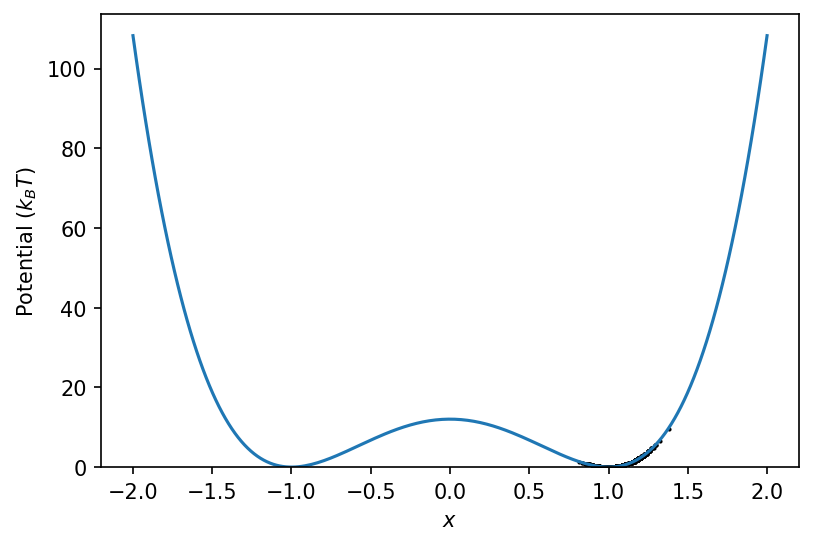

In [16]:
vis.scatter_traj_projection_x(traj[2000::10])  # only every 10, for speed

### Visualizing trajectories from all the windows

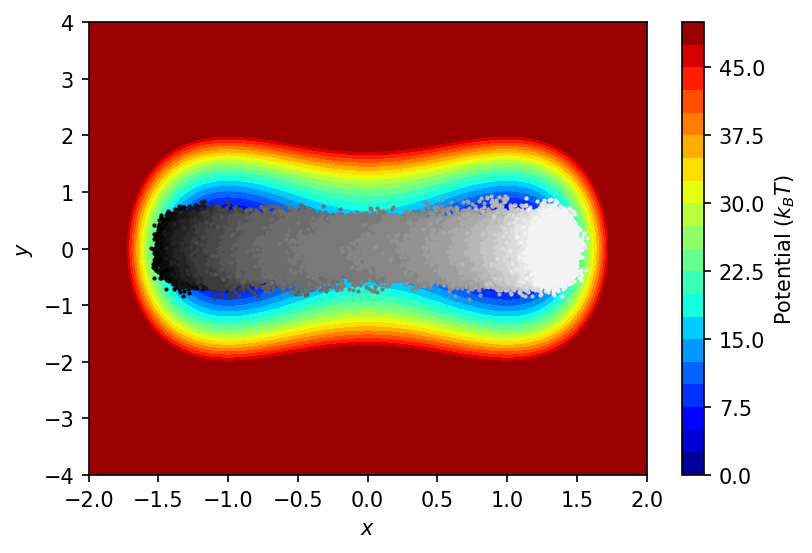

In [17]:
fig, ax = vis.plot_potential()

cmap = plt.get_cmap('gist_gray')
ax.set_prop_cycle(color=[cmap(1.*i/len(x_win)) for i in range(len(x_win))])

for x_0 in x_win:
    t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k{}x{:.2f}/traj.dat".format(kappa, x_0)).read_traj()
    ax.scatter(traj[2000:, 0], traj[2000:, 1], s=1)

### Visualizing histograms along $x$ coordinate

Text(0, 0.5, 'Count')

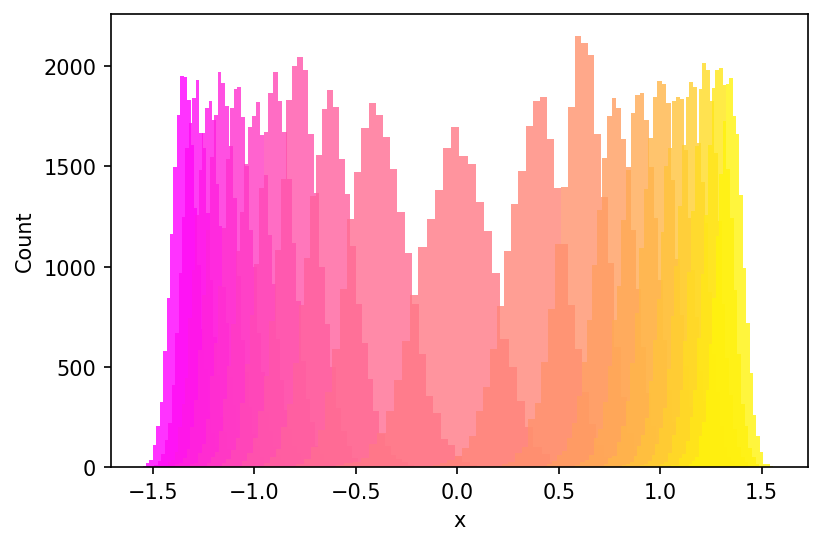

In [18]:
fig, ax = plt.subplots(dpi=150)

cmap = plt.get_cmap('spring')
ax.set_prop_cycle(color=[cmap(1.*i/len(x_win)) for i in range(len(x_win))])

for x_0 in x_win:
    t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k{}x{:.2f}/traj.dat".format(kappa, x_0)).read_traj()
    ax.hist(traj[2000:, 0], bins=30, alpha=0.8)
    
ax.set_xlabel("x")
ax.set_ylabel("Count")

## WHAM

We'll now use binless and binned WHAM to construct free energy landscapes from the biased data we collected.

In [19]:
# Data
x_it = []
for x_0 in x_win:
    t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k{}x{:.2f}/traj.dat".format(kappa, x_0)).read_traj()
    x_it.append(traj[2000:, 0])
    
# Umbrella potentials
u_i = []
for x_0 in x_win:
    u_i.append(potentials.harmonic(kappa, x_0))
    
# Bins for free energy profile
x_bin = np.linspace(-1.5, 1.5, 101)

# Beta
beta = 1000 / (8.3145 * 300)

### Binless WHAM

Text(0, 0.5, 'Free energy ($k_B T$)')

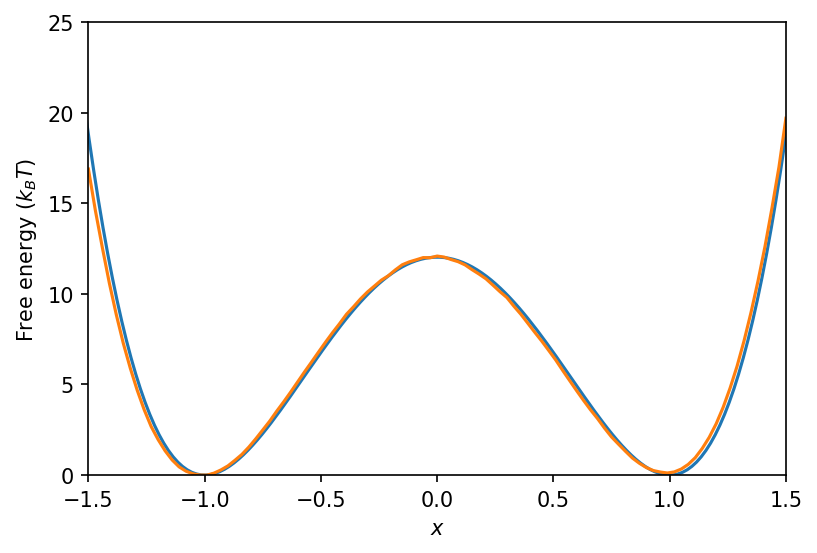

In [20]:
calc_binless = binless.Calc1D()
bF, _, _ = calc_binless.compute_betaF_profile(x_it, x_bin, u_i, beta=beta)
bF = bF - np.min(bF)
fig, ax, _, _ = vis.plot_projection_x() 
ax.plot(x_bin, bF)
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0, 25)
ax.set_ylabel(r"Free energy ($k_B T$)")

In [21]:
# Compute L2 relative error
bF_true = beta * (30 * (x_bin ** 2 - 1) ** 2)
L2_relative = np.sqrt(np.sum((bF - bF_true) ** 2)) / np.sqrt(np.sum(bF_true ** 2))
print("{:.2f} pct error".format(L2_relative * 100))

5.87 pct error


### Binned WHAM

Text(0, 0.5, 'Free energy ($k_B T$)')

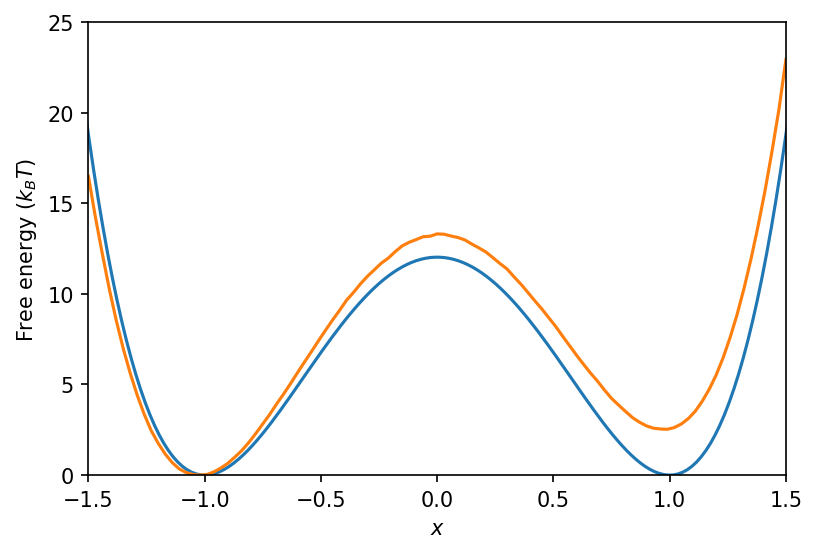

In [22]:
calc_binned = binned.Calc1D()
calc_binned.compute_betaF_profile(x_it, x_bin, u_i, beta=beta)
bF = calc_binned.betaF_l
bF = bF - np.min(bF)
fig, ax, _, _ = vis.plot_projection_x()
ax.plot(x_bin, bF - np.min(bF))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(0, 25)
ax.set_ylabel(r"Free energy ($k_B T$)")

In [23]:
# Compute L2 relative error
bF_true = beta * (30 * (x_bin ** 2 - 1) ** 2)
L2_relative = np.sqrt(np.sum((bF - bF_true) ** 2)) / np.sqrt(np.sum(bF_true ** 2))
print("{:.2f} pct error".format(L2_relative * 100))

23.33 pct error


## How good are the WHAM results?

### Binless WHAM

[0.0068996  0.00203752 0.00230261 0.00368129 0.00175416 0.00222092
 0.00173307 0.00308138 0.00267681 0.00146737 0.00206345 0.00179322
 0.00213535 0.00269823 0.00350778 0.0043574  0.0024529  0.00304847
 0.00337979 0.00147224 0.00250437]


Text(0, 0.5, '$D_{KL}$')

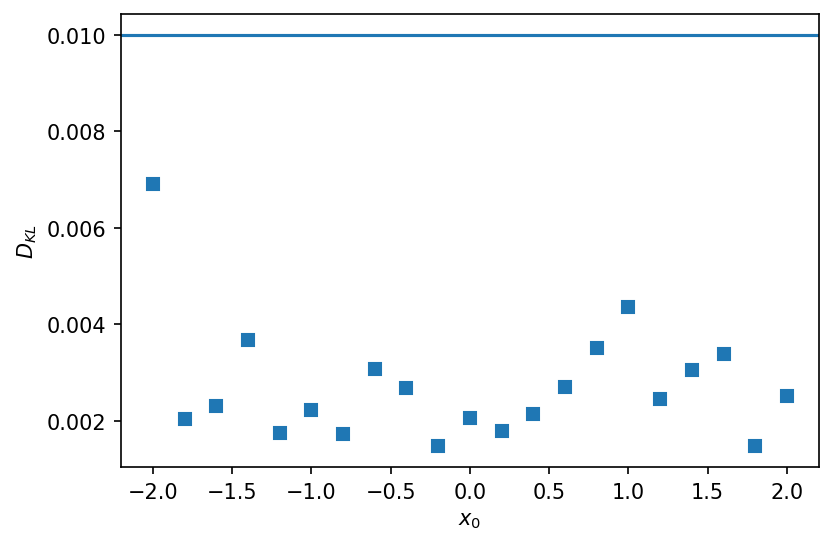

In [24]:
D_KL_i = statistics.binless_KLD_reweighted_win_betaF(calc_binless, x_it, x_bin, u_i, beta)
print(D_KL_i)

fig, ax = plt.subplots(dpi=150)
ax.plot(x_win, D_KL_i, 's')
ax.axhline(y=0.01)
ax.set_xlabel(r"$x_0$")
ax.set_ylabel(r"$D_{KL}$")

## Reweighting to $\phi$-ensemble

In [25]:
phivals = np.arange(-10, 10, 0.01)
# binless phi-ensemble
x_avg, x_var = statistics.binless_reweight_phi_ensemble(calc_binless, phivals, beta)

# binned phi-ensemble
x_avg_bin, x_var_bin = statistics.binned_reweight_phi_ensemble(x_bin, bF, phivals, beta)

Text(0, 0.5, '$\\langle \\delta x^2 \\rangle$')

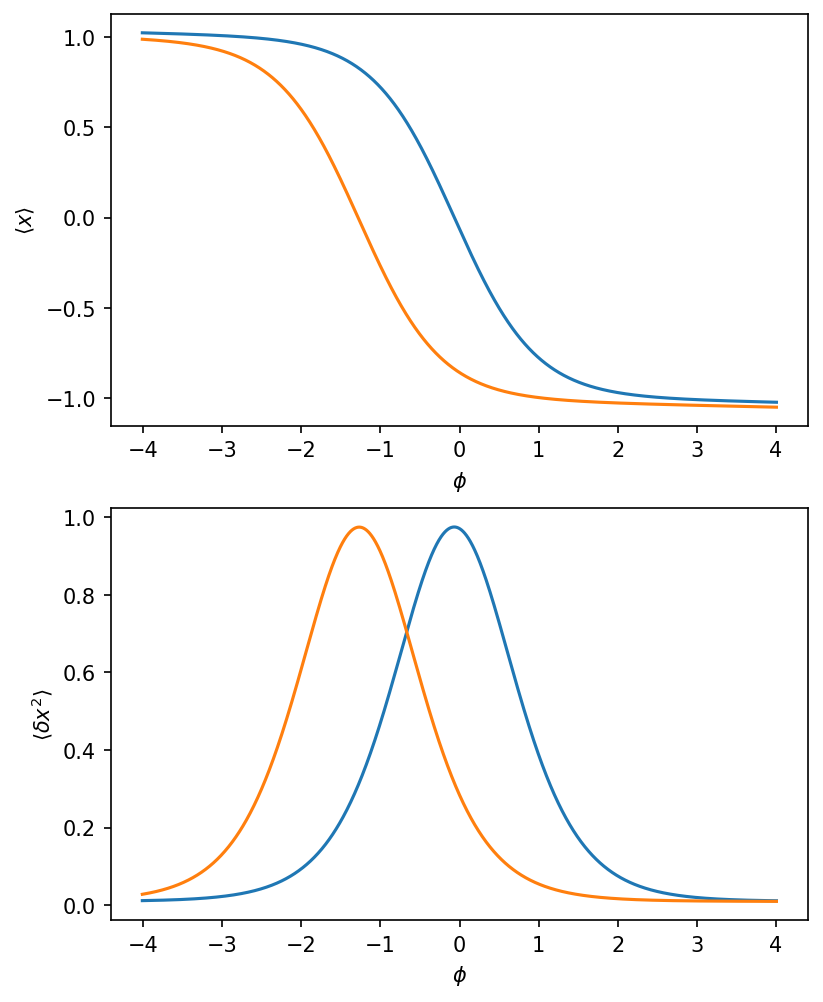

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(6, 8), dpi=150)
ax[0].plot(beta * phivals, x_avg, label="Binless")
ax[0].plot(beta * phivals, x_avg_bin, label="Binned")
ax[0].set_xlabel(r"$\phi$")
ax[0].set_ylabel(r"$\langle x \rangle$")

ax[1].plot(beta * phivals, x_var, label="Binless")
ax[1].plot(beta * phivals, x_var_bin, label="Binned")
ax[1].set_xlabel(r"$\phi$")
ax[1].set_ylabel(r"$\langle \delta x^2 \rangle$")

## Computing 2D profiles from 1D WHAM

In [27]:
# Data
y_it = []
for x_0 in x_win:
    t, traj = single_particle_ld.TrajectoryReader("examples_out/1D_US/biased/k{}x{:.2f}/traj.dat".format(kappa, x_0)).read_traj()
    y_it.append(traj[2000:, 1])
    
# Unroll
y_l = y_it[0]
for i in range(1, len(y_it)):
    y_l = np.hstack((y_l, y_it[i]))
    
# Bins
y_bin = np.linspace(-1, 1, 101)

### Binless WHAM

In [28]:
bF_xy, _ = calc_binless.bin_2D_betaF_profile(y_l, x_bin, y_bin)

bF_xy = bF_xy - np.min(bF_xy)

Text(0.5, 1.0, 'Free energy $(k_B T)$')

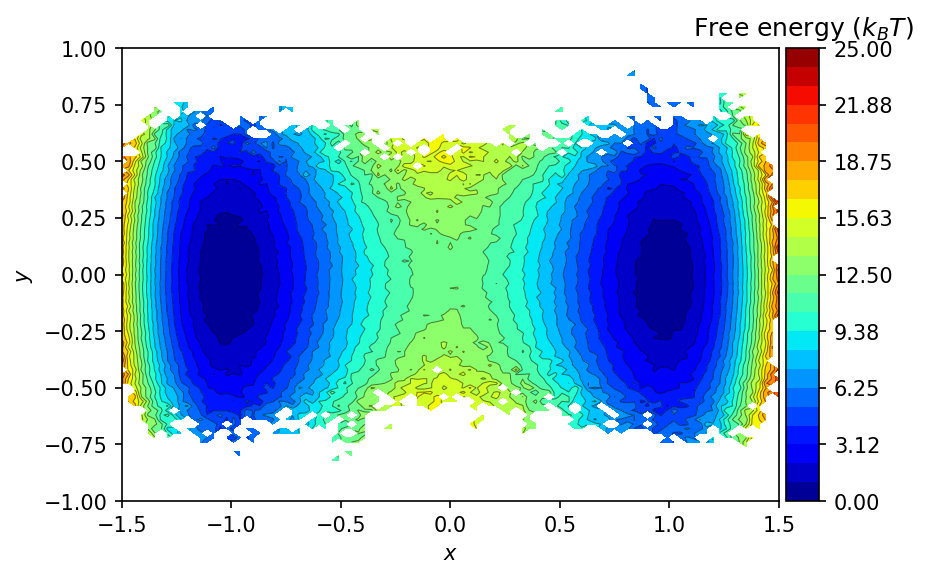

In [29]:
fig, ax = plt.subplots(dpi=150)

levels = np.linspace(0, 25, 25)
cmap = cm.jet
contour_filled = ax.contourf(x_bin, y_bin, bF_xy.T, levels, cmap=cm.get_cmap(cmap, len(levels) - 1))
ax.contour(contour_filled, colors='k', alpha=0.5, linewidths=0.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(contour_filled, cax=cax, orientation='vertical')

ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1, 1])

cax.set_title(r"Free energy $(k_B T)$")